In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string

from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from typing import Union

In [2]:
# Loading CSVs into Pandas DataFrame
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
X_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
# Splitting train_df into Training and Validation Sets.
y_train_val = train_df.Survived
X_train_val = train_df.drop(columns=['Survived'])

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20)

# Shared Functions

In [4]:
def evaluate_model(model: BaseEstimator,
                   X_train: pd.DataFrame,
                   y_train: pd.Series,
                   X_val: pd.DataFrame,
                   y_val: pd.Series) -> dict[str: Union[str, float]]:
    """
    Returns accuracy on training and validation sets. 
    
    Args:
        X_train (pd.DataFrame): Training features.
        X_val (pd.DataFrame): Validation features.
    
    Returns:
        (dict[str: Union[str, float]]): dictionary of training and validation
            accuracies for model.
    """
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    train_accuracy = accuracy_score(
        y_true=y_train, y_pred=y_pred_train)
    val_accuracy = accuracy_score(
        y_true=y_val, y_pred=y_pred_val)

    # Getting human readable model name
    model_name = str(type(model)).split("'")[-2]

    return {
        'model': model_name,
        'training_accuracy': train_accuracy,
        'validation_accuracy': val_accuracy
    }

# Models
## Gender Model

In [5]:
class GenderModel(BaseEstimator):
    def predict(self, X) -> np.ndarray:
        """
        Predicts whether a passenger survives the Titanic solely based on gender.
        Women are predicted to survive, men are not.
    
        Args:
            X (pd.DataFrame): Pandas Dataframe containing 'Sex' column.
    
        Returns:
            pd.Series: True if female, False otherwise.
        """
        return np.where(X['Sex'] == 'female', 1, 0)

In [6]:
gender_model = GenderModel()

## Random Forest

In [7]:
def get_deck(row: pd.Series) -> str:
    """
    Gets the Deck of a Titanic Ticket.  The Deck of a Titanic Ticket is the first
    Character of the Ticket if there's a space in it.  Else 'Numeric'.

    Args:
        row (pd.Series): Row of titanic training data.

    Returns:
        str: Deck of a Titanic Ticket.
    """
    ticket = row['Ticket']
    if len(ticket.split()) > 1:
        return ticket[0]
    else:
        return 'Numeric'

In [8]:
def get_clean_name_words(row) -> list[str]:
    """
    Listifies, lowercases, and removes punctuation from row['Name'].

    Args:
        row (pd.Series): Row of titanic training data.

    Retruns:
        list[str]: A list of strings.  Each list is each token of row['Name']
        lowercased and stripped of punctuation.
    """
    name = row['Name']
    name_lower = name.lower()
    name_lower_no_punct = name_lower.translate(
        str.maketrans('', '', string.punctuation))
    return name_lower_no_punct.split()

In [9]:
def preprocess_random_forest(df: pd.DataFrame) -> pd.DataFrame:
    """
    Puts data in format expected by Random Forest classifier.
    
    Args:
        df (pd.DataFrame): DataFrame for training or inference.

    Returns:
        pd.DataFrame: Subset of df with engineered columns defined by features
            where multiclass variables are binarized.
    """  
    df['Deck'] = df.apply(get_deck, axis=1)
    df['Clean_Name_Words'] = df.apply(get_clean_name_words, axis=1)
    
    # Assuming all passengers with null ages are 40.
    df['Age_not_null'] = df['Age'].fillna(40)
    # Assuming all passengers will null Fares paid $0.
    df['Fare_not_null'] = df['Fare'].fillna(0)

    # Creating features based on Cabin.
    df['no_cabin'] = df.apply(lambda row: pd.isnull(row['Cabin']), axis=1)
    df['cabin_first_char'] = df['Cabin'].apply(
        lambda row: row[0] if pd.notnull(row) else row)

    # One hot encoding gender, embarkment location, Deck, and cabin_first_char.
    df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Deck',
                                     'cabin_first_char'])
    df.columns = ['is_male' if x == 'Sex_male' else x for x in df.columns]

    # Creating indicator features based on Name.
    df['is_married_adult_woman'] = df.apply(
        lambda row: not row['is_male']
        and 'mrs' in row['Clean_Name_Words']
        and row['Age_not_null'] >= 21, axis=1)
    df['is_unmarried_adult_woman'] = df.apply(
        lambda row: not row['is_male']
        and 'miss' in row['Clean_Name_Words']
        and row['Age_not_null'] >= 21, axis=1)
    df['is_master'] = df.apply(lambda row: 'master' in row['Clean_Name_Words'], axis=1)
    df['is_dr']     = df.apply(lambda row: 'dr' in row['Clean_Name_Words'], axis=1)
    df['is_rev']    = df.apply(lambda row: 'rev' in row['Clean_Name_Words'], axis=1)
    return df

In [10]:
def fit_random_forest(X_train: pd.DataFrame,
                       y_train: pd.Series,
                       n_estimators: int,
                       max_depth: int,
                       max_features: int) -> RandomForestClassifier:
    """
    Fits a Random Forest binary classifier to the training data.
    
    Args:
        X_train (pd.DataFrame): Feature variables used for Random Forest.
        y_train (pd.Series): Target variable used for Random Forest.
        n_estimators (int): The number of trees in the forest.
        max_depth (int): The maximum depth of the tree.
        max_features (int): The number of features to consider when looking
            for the best split.

    Returns:
        RandomForestClassifier: A fit sklearn.ensemble.RandomForestClassifier
            according to n_estimators.
    """
    model = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, max_features=max_features,
        random_state=1)
    model.fit(X_train, y_train)
    
    return model

### Feature Selection

In [11]:
features = ["Pclass", "SibSp", "Parch", "is_male", "Embarked_C", "Embarked_Q",
            "Deck_A", "Deck_F", "Deck_P", "Deck_W", "no_cabin",
            "cabin_first_char_A", "cabin_first_char_B", "cabin_first_char_C",
            "cabin_first_char_D", "cabin_first_char_E", "cabin_first_char_F",
            "cabin_first_char_G", "cabin_first_char_T", "Age_not_null",
            "Fare_not_null", "is_married_adult_woman","is_unmarried_adult_woman",
            "is_master", "is_dr", "is_rev"]

X_train_preprocessed_rf = preprocess_random_forest(X_train).reindex(
    columns=features, fill_value=0)

# Ensuring columns in X_val_preprocessed_rf are the same as the columns in
# X_train_preprocessed_rf since we have one hot encodings
X_val_preprocessed_rf = preprocess_random_forest(X_val).reindex(
    columns=features, fill_value=0)

### Hyperparameter Tuning

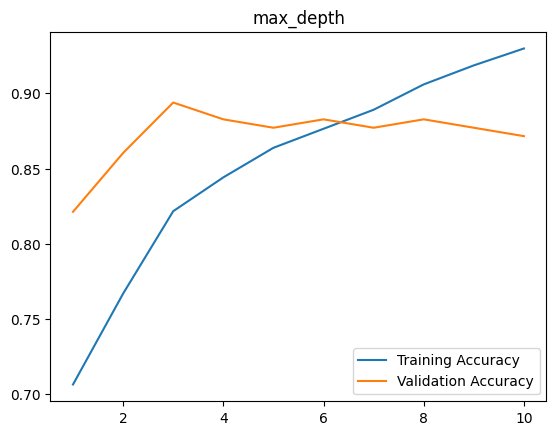

In [12]:
# It's impossible to have a tree with depth >= len(features)
max_depths = list(range(
    1,
    min(11, len(features)+1),
    1
))
training_accuracies = []
validation_accuracies = []

for max_depth in max_depths:
    # Training model
    random_forrest_model = fit_random_forest(
        X_train_preprocessed_rf, y_train, n_estimators=500, max_depth=max_depth,
        max_features='sqrt')
    # Evaluating model
    accuracies = evaluate_model(
        model=random_forrest_model, X_train=X_train_preprocessed_rf,
        y_train=y_train, X_val=X_val_preprocessed_rf, y_val=y_val)
    training_accuracies.append(accuracies['training_accuracy'])
    validation_accuracies.append(accuracies['validation_accuracy'])

plt.plot(max_depths, training_accuracies)
plt.plot(max_depths, validation_accuracies)
plt.title("max_depth")
plt.legend(('Training Accuracy', 'Validation Accuracy'), loc='lower right')
plt.show()

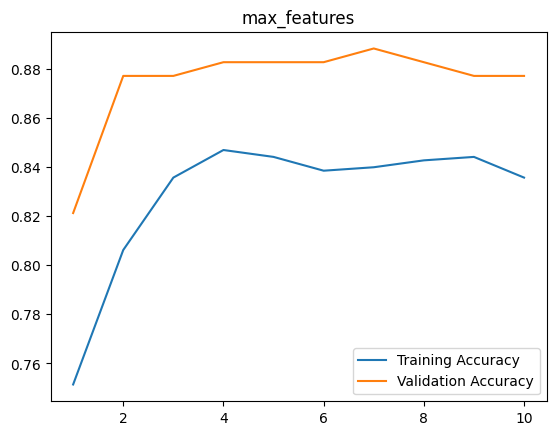

In [13]:
# It's impossible to consider more features than len(features) for a split.
max_features = list(range(
    1,
    min(11, len(features)+1),
    1
))
training_accuracies = []
validation_accuracies = []

for max_feature in max_features:
    # Training model
    random_forrest_model = fit_random_forest(
        X_train_preprocessed_rf, y_train, n_estimators=500, max_depth=4,
        max_features=max_feature)
    # Evaluating model
    accuracies = evaluate_model(
        model=random_forrest_model, X_train=X_train_preprocessed_rf,
        y_train=y_train, X_val=X_val_preprocessed_rf, y_val=y_val)
    training_accuracies.append(accuracies['training_accuracy'])
    validation_accuracies.append(accuracies['validation_accuracy'])

plt.plot(max_depths, training_accuracies)
plt.plot(max_depths, validation_accuracies)
plt.title("max_features")
plt.legend(('Training Accuracy', 'Validation Accuracy'), loc='lower right')
plt.show()

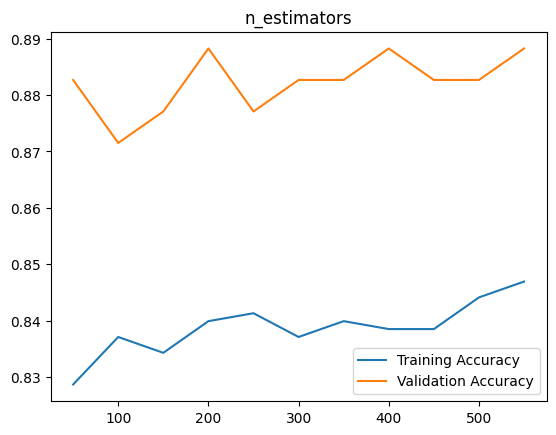

In [14]:
# It's impossible to consider more features than len(features) for a split.
num_estimators = list(range(
    50,
    600,
    50
))
training_accuracies = []
validation_accuracies = []

for n_estimator in num_estimators:
    # Training model
    random_forrest_model = fit_random_forest(
        X_train_preprocessed_rf, y_train, n_estimators=n_estimator, max_depth=4,
        max_features='sqrt')
    # Evaluating model
    accuracies = evaluate_model(
        model=random_forrest_model, X_train=X_train_preprocessed_rf,
        y_train=y_train, X_val=X_val_preprocessed_rf, y_val=y_val)
    training_accuracies.append(accuracies['training_accuracy'])
    validation_accuracies.append(accuracies['validation_accuracy'])

plt.plot(num_estimators, training_accuracies)
plt.plot(num_estimators, validation_accuracies)
plt.title("n_estimators")
plt.legend(('Training Accuracy', 'Validation Accuracy'), loc='lower right')
plt.show()

In [15]:
random_forest_model = fit_random_forest(X_train_preprocessed_rf, y_train,
                                        n_estimators=150, max_depth=4,
                                        max_features='sqrt')

## XGBoost

In [16]:
# TODO read
# https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

In [17]:
# Generally, XGBoost is fast. Really fast when compared to other implementations
# of gradient boosting.
# Sparse Aware
from xgboost import XGBRFClassifier

xgboost_model = XGBRFClassifier(
    n_estimators=500, subsample=0.9, colsample_bynode=0.2)

xgboost_model.fit(X_train_preprocessed_rf, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=0.2,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=500, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=None, ...)

In [18]:
evaluate_model(model=xgboost_model, X_train=X_train_preprocessed_rf,
               y_train=y_train, X_val=X_val_preprocessed_rf, y_val=y_val)

{'model': 'xgboost.sklearn.XGBRFClassifier',
 'training_accuracy': 0.8497191011235955,
 'validation_accuracy': 0.8715083798882681}

In [19]:
# TODO:
# Tune
# n_estimators
# * values up to 750(?)
# colsample_bynode
# * values from 0.0 to 1.0 with an increment of 0.1

### Leaderboard

In [20]:
# Adding models to the Leaderboard.
gender_model_evaluation = evaluate_model(
    model=gender_model, X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val)

random_forest_evaluation = evaluate_model(
    model=random_forest_model, X_train=X_train_preprocessed_rf, y_train=y_train,
    X_val=X_val_preprocessed_rf, y_val=y_val)

xgb_evaluation = evaluate_model(
    model=xgboost_model, X_train=X_train_preprocessed_rf,
    y_train=y_train, X_val=X_val_preprocessed_rf, y_val=y_val)

In [21]:
leaderboard = pd.DataFrame([
gender_model_evaluation, random_forest_evaluation, xgb_evaluation])

leaderboard.sort_values(by='validation_accuracy', ascending=False, inplace=True)

leaderboard.head(len(leaderboard))

,model,training_accuracy,validation_accuracy
0,__main__.GenderModel,0.762640,0.882682
1,sklearn.ensemble._forest.RandomForestClassifier,0.834270,0.877095
2,xgboost.sklearn.XGBRFClassifier,0.849719,0.871508


# Submission

In [22]:
# Predicting on X_test.
X_test_preprocessed_rf = preprocess_random_forest(X_test).reindex(
    columns=features, fill_value=0)
y_pred_test = random_forest_model.predict(X_test_preprocessed_rf[features])

submission_df = pd.DataFrame({
    "PassengerId": X_test.PassengerId,
    "Survived": y_pred_test
})

submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [23]:
submission_df.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")

Submission saved to submission.csv
